In [1]:
cd ../../src

/Users/in-divye.singh/Documents/Projects/MIC_predictor/src


In [2]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain, combinations
from collections import Counter

from utils import *

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [4]:
avp_ic50 = pd.read_csv("../data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("../data/raw/HA_AVP.csv")

In [5]:
df = pd.concat([avp_ic50[['Sequence','MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)

In [6]:
df

,Sequence,MIC
0,AAQRRGRVGRNPNQVGD,442.00000
1,HRILARIRQMMT,435.50000
2,RNPSQVGD,383.00000
3,RVGRNPNQVGD,374.00000
4,AAQRRGRIGRNPSQVGD,358.00000
...,...,...
707,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515
708,CFPYITRPGTYHDWWYTRKNRQ,0.30000
709,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131
710,GTNLSVPNPLGFFPDHQLDPAFGANSNNPDWDFNPNKDHWPEANKVG,0.00008


In [28]:
contact_energy_matrix = pd.read_csv("../data/raw/contact_energy.csv", index_col=0)

In [29]:
contact_energy_matrix

,Ala,Cys,Asp,Glu,Phe,Gly,His,Ile,Lys,Leu,Met,Asn,Pro,Gln,Arg,Ser,Thr,Val,Trp,Tyr
Ala,-2.72,-3.57,-1.70,-1.51,-4.81,-2.31,-2.41,-4.58,-1.31,-4.91,-3.94,-1.84,-2.03,-1.89,-1.83,-2.01,-2.32,-4.04,-3.82,-3.36
Cys,-3.57,-5.44,-2.41,-2.27,-5.80,-3.16,-3.60,-5.50,-1.95,-5.83,-4.99,-2.59,-3.07,-2.85,-2.57,-2.86,-3.11,-4.96,-4.95,-4.16
Asp,-1.70,-2.41,-1.21,-1.02,-3.48,-1.59,-2.32,-3.17,-1.68,-3.40,-2.57,-1.68,-1.33,-1.46,-2.29,-1.63,-1.80,-2.48,-2.84,-2.76
Glu,-1.51,-2.27,-1.02,-0.91,-3.56,-1.22,-2.15,-3.27,-1.80,-3.59,-2.89,-1.51,-1.26,-1.42,-2.27,-1.48,-1.74,-2.67,-2.99,-2.79
Phe,-4.81,-5.80,-3.48,-3.56,-7.26,-4.13,-4.77,-6.84,-3.36,-7.28,-6.56,-3.75,-4.25,-4.10,-3.98,-4.02,-4.28,-6.29,-6.16,-5.66
Gly,-2.31,-3.16,-1.59,-1.22,-4.13,-2.24,-2.15,-3.78,-1.15,-4.16,-3.39,-1.74,-1.87,-1.66,-1.72,-1.82,-2.08,-3.38,-3.42,-3.01
His,-2.41,-3.60,-2.32,-2.15,-4.77,-2.15,-3.05,-4.14,-1.35,-4.54,-3.98,-2.08,-2.25,-1.98,-2.16,-2.11,-2.42,-3.58,-3.98,-3.52
Ile,-4.58,-5.50,-3.17,-3.27,-6.84,-3.78,-4.14,-6.54,-3.01,-7.04,-6.02,-3.24,-3.76,-3.67,-3.63,-3.52,-4.03,-6.05,-5.78,-5.25
Lys,-1.31,-1.95,-1.68,-1.80,-3.36,-1.15,-1.35,-3.01,-0.12,-3.37,-2.48,-1.21,-0.97,-1.29,-0.59,-1.05,-1.31,-2.49,-2.69,-2.60
Leu,-4.91,-5.83,-3.40,-3.59,-7.28,-4.16,-4.54,-7.04,-3.37,-7.37,-6.41,-3.74,-4.20,-4.04,-4.03,-3.92,-4.34,-6.48,-6.14,-5.67


In [10]:
code3_to_code1 = pd.read_excel("../data/raw/amino_acid_codes.xlsx")

In [23]:
code3_to_code1_dict = dict(code3_to_code1[['Three-letter symbol', 'One-letter symbol']].values)
code3_to_code1_dict

{'Ala': 'A',
 'Asx': 'B',
 'Cys': 'C',
 'Asp': 'D',
 'Glu': 'E',
 'Phe': 'F',
 'Gly': 'G',
 'His': 'H',
 'Ile': 'I',
 'Lys': 'K',
 'Leu': 'L',
 'Met': 'M',
 'Asn': 'N',
 'Pro': 'P',
 'Gln': 'Q',
 'Arg': 'R',
 'Ser': 'S',
 'Thr': 'T',
 'Sec': 'U*',
 'Val': 'V',
 'Trp': 'W',
 'Xaa': 'X**',
 'Tyr': 'Y',
 'Glx': 'Z'}

In [30]:
contact_energy_matrix.columns = [code3_to_code1_dict[code] for code in contact_energy_matrix.columns]
contact_energy_matrix.index = [code3_to_code1_dict[code] for code in contact_energy_matrix.index]
contact_energy_matrix

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
A,-2.72,-3.57,-1.70,-1.51,-4.81,-2.31,-2.41,-4.58,-1.31,-4.91,-3.94,-1.84,-2.03,-1.89,-1.83,-2.01,-2.32,-4.04,-3.82,-3.36
C,-3.57,-5.44,-2.41,-2.27,-5.80,-3.16,-3.60,-5.50,-1.95,-5.83,-4.99,-2.59,-3.07,-2.85,-2.57,-2.86,-3.11,-4.96,-4.95,-4.16
D,-1.70,-2.41,-1.21,-1.02,-3.48,-1.59,-2.32,-3.17,-1.68,-3.40,-2.57,-1.68,-1.33,-1.46,-2.29,-1.63,-1.80,-2.48,-2.84,-2.76
E,-1.51,-2.27,-1.02,-0.91,-3.56,-1.22,-2.15,-3.27,-1.80,-3.59,-2.89,-1.51,-1.26,-1.42,-2.27,-1.48,-1.74,-2.67,-2.99,-2.79
F,-4.81,-5.80,-3.48,-3.56,-7.26,-4.13,-4.77,-6.84,-3.36,-7.28,-6.56,-3.75,-4.25,-4.10,-3.98,-4.02,-4.28,-6.29,-6.16,-5.66
G,-2.31,-3.16,-1.59,-1.22,-4.13,-2.24,-2.15,-3.78,-1.15,-4.16,-3.39,-1.74,-1.87,-1.66,-1.72,-1.82,-2.08,-3.38,-3.42,-3.01
H,-2.41,-3.60,-2.32,-2.15,-4.77,-2.15,-3.05,-4.14,-1.35,-4.54,-3.98,-2.08,-2.25,-1.98,-2.16,-2.11,-2.42,-3.58,-3.98,-3.52
I,-4.58,-5.50,-3.17,-3.27,-6.84,-3.78,-4.14,-6.54,-3.01,-7.04,-6.02,-3.24,-3.76,-3.67,-3.63,-3.52,-4.03,-6.05,-5.78,-5.25
K,-1.31,-1.95,-1.68,-1.80,-3.36,-1.15,-1.35,-3.01,-0.12,-3.37,-2.48,-1.21,-0.97,-1.29,-0.59,-1.05,-1.31,-2.49,-2.69,-2.60
L,-4.91,-5.83,-3.40,-3.59,-7.28,-4.16,-4.54,-7.04,-3.37,-7.37,-6.41,-3.74,-4.20,-4.04,-4.03,-3.92,-4.34,-6.48,-6.14,-5.67


In [39]:
def seq_to_contact_energy(seq):
    return [contact_energy_matrix[r][c] for r,c in list(zip(seq[:-1],seq[1:]))]

In [40]:
df['contact_energy'] = df['Sequence'].apply(seq_to_contact_energy)

In [42]:
df['net_contact_energy'] = df['contact_energy'].apply(lambda s: np.sum(s))

In [43]:
df

,Sequence,MIC,contact_energy,net_contact_energy
0,AAQRRGRVGRNPNQVGD,442.00000,"[-2.72, -1.89, -1.8, -1.55, -1.72, -1.72, -3.0...",-34.02
1,HRILARIRQMMT,435.50000,"[-2.16, -3.63, -7.04, -4.91, -1.83, -3.63, -3....",-40.90
2,RNPSQVGD,383.00000,"[-1.64, -1.53, -1.57, -1.49, -3.07, -3.38, -1.59]",-14.27
3,RVGRNPNQVGD,374.00000,"[-3.07, -3.38, -1.72, -1.64, -1.53, -1.53, -1....",-22.62
4,AAQRRGRIGRNPSQVGD,358.00000,"[-2.72, -1.89, -1.8, -1.55, -1.72, -1.72, -3.6...",-34.80
...,...,...,...,...
707,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515,"[-1.74, -2.31, -4.58, -5.5, -4.95, -3.42, -1.8...",-92.70
708,CFPYITRPGTYHDWWYTRKNRQ,0.30000,"[-5.8, -4.25, -3.19, -5.25, -4.03, -1.9, -1.7,...",-61.63
709,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131,"[-3.01, -1.96, -3.92, -7.04, -4.14, -2.11, -3....",-108.13
710,GTNLSVPNPLGFFPDHQLDPAFGANSNNPDWDFNPNKDHWPEANKVG,0.00008,"[-2.08, -1.88, -3.74, -3.92, -3.05, -3.32, -1....",-122.85


In [44]:
import seaborn as sns

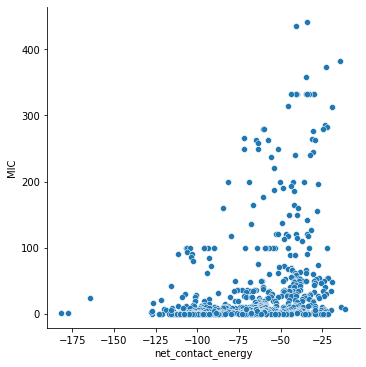

In [45]:
sns.relplot(x=df['net_contact_energy'], y=df['MIC'])

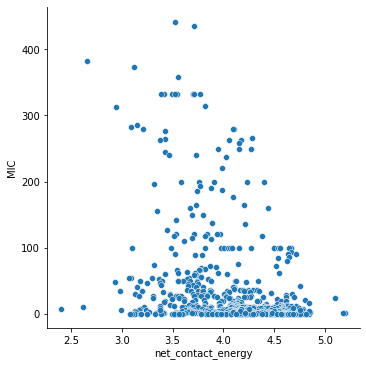

In [54]:
sns.relplot(x=np.log(-1*df['net_contact_energy']), y=df['MIC'])

In [57]:
list(zip(range(len(df)), np.log(-1*df['net_contact_energy']), df['MIC'], df['net_contact_energy']))

[(0, 3.5269485869677157, 442.0, -34.019999999999996),
 (1, 3.711130063048756, 435.5, -40.9),
 (2, 2.658159431488745, 383.0, -14.27),
 (3, 3.1188344706879745, 374.0, -22.619999999999997),
 (4, 3.5496173867804286, 358.0, -34.8),
 (5, 3.4154289639088797, 333.0, -30.429999999999996),
 (6, 3.3884498088396526, 333.0, -29.62),
 (7, 3.492864570187979, 333.0, -32.88),
 (8, 3.5406694269487495, 333.0, -34.49),
 (9, 3.5234150143864045, 333.0, -33.9),
 (10, 3.6990772790903823, 333.0, -40.41),
 (11, 3.702782359282928, 333.0, -40.56),
 (12, 3.709417105331484, 333.0, -40.83),
 (13, 3.7727609380946383, 333.0, -43.5),
 (14, 3.822098297900159, 315.0, -45.7),
 (15, 2.9391619220655967, 313.0, -18.9),
 (16, 3.152736022363656, 285.0, -23.4),
 (17, 3.0951250174320255, 283.0, -22.089999999999996),
 (18, 3.21124679770371, 280.0, -24.81),
 (19, 4.106931677727572, 280.0, -60.760000000000005),
 (20, 4.09567700745588, 278.801, -60.08),
 (21, 3.427189961936409, 277.0, -30.789999999999996),
 (22, 4.278470046515581, 2

In [65]:
df.iloc[[47,48,49,50,59,60]+list(range(69,89)),:]

,Sequence,MIC,contact_energy,net_contact_energy
47,VPCSICSNNPTCWAICKRIPNKKPGKK,165.0,"[-3.32, -3.07, -2.86, -3.52, -5.5, -2.86, -1.5...",-66.68
48,YQALIRMIYKNI,165.0,"[-2.97, -1.89, -4.91, -7.04, -3.63, -3.12, -6....",-41.88
49,FGGASCCLYCRCHIDHPNPKGFCDLKGKY,160.0,"[-4.13, -2.24, -2.31, -2.01, -2.86, -5.44, -5....",-84.46
50,GGASCCLYCRCH,160.0,"[-2.24, -2.31, -2.01, -2.86, -5.44, -5.83, -5....",-39.26
59,YQLLIRMI,120.0,"[-2.97, -4.04, -7.37, -7.04, -3.63, -3.12, -6.02]",-34.19
60,ESELVSQIIEQLIKK,120.0,"[-1.48, -1.48, -3.59, -6.48, -3.05, -1.49, -3....",-46.68
69,PDAVYLHRIDLGPPISLERLDVGTNLGNAIAKLED,100.0,"[-1.33, -1.7, -4.04, -4.62, -5.67, -4.54, -2.1...",-106.28
70,DAVYLHRIDLGPPISLERLDVGTNLQNAIAKLEDA,100.0,"[-1.7, -4.04, -4.62, -5.67, -4.54, -2.16, -3.6...",-106.50
71,AVYLHRIDLGPPISLERLDVGTNLQNAIAKLEDAK,100.0,"[-4.04, -4.62, -5.67, -4.54, -2.16, -3.63, -3....",-106.11
72,YTPNDITLNNSVALDPIDISIELNKAKSDLEESKE,100.0,"[-3.01, -1.9, -1.53, -1.68, -3.17, -4.03, -4.3...",-89.87


In [67]:
avpdb = pd.read_excel("../../PeptideGAN/antiviral-peptide-predictions-using-gan/data/excel_sheets/AVPdb_data.xls")

In [68]:
avpdb

,Id,Sequence,Length,Virus,Abbreviation,Family,Nomenclature,Source,Uniprot,Cell_Line,Inhibition/IC50,Unit,Target,Assay,Accession,Title,Authors,Reference
0,AVP0001,PYVGSGLYRR,10,Avian myeloblastosis virus,AMV,Retroviridae,p2-p10,RSV gag polyprotein,P03354,-,50,μM,Release,Protease activity assay,1331099,Mechanism of inhibition of the retroviral prot...,"Cameron CE, Grinde B, Jentoft J, Leis J, Weber...",J Biol Chem. 1992
1,AVP0002,SMIENLEYM,9,Lymphocytic choriomeningitis virus,LCMV,Arenaviridae,-,Synthetic,NaN,MC57,50,μM,CTL lysis,In vitro cytotoxicity assay,1383569,Design of high-affinity major histocompatibili...,"Gairin JE, Oldstone MB.",J Virol. 1992
2,AVP0003,ECRSTSYAGAVVNDL,15,Herpes simplex virus 1,HSV 1,Herpesviridae,H2-(1-15),HSV ribonucleotide reductase subunit 2,P10224,BHK-21/C,42,μM,Replication,Ribonucleotide reductase assay,3040743,Structure-activity studies on synthetic peptid...,"Gaudreau P, Michaud J, Cohen EA, Langelier Y, ...",J Biol Chem. 1987
3,AVP0004,STSYAGAVVNDL,12,Herpes simplex virus 1,HSV 1,Herpesviridae,H2-(4-15),HSV ribonucleotide reductase subunit 2,P10224,BHK-21/C,29,μM,Replication,Ribonucleotide reductase assay,3040743,Structure-activity studies on synthetic peptid...,"Gaudreau P, Michaud J, Cohen EA, Langelier Y, ...",J Biol Chem. 1987
4,AVP0005,YAGAVVNDL,9,Herpes simplex virus 1,HSV 1,Herpesviridae,H2-(7-15),HSV ribonucleotide reductase subunit 2,P10224,BHK-21/C,60,μM,Replication,Ribonucleotide reductase assay,3040743,Structure-activity studies on synthetic peptid...,"Gaudreau P, Michaud J, Cohen EA, Langelier Y, ...",J Biol Chem. 1987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,AVP2058,LFRLIKSLIKRLVSAFK,17,Influenza A virus,INFV A,Orthomyxoviridae,Mucroporin-S2,Scorpion venom,B9UIY3,MDCK,No,NaN,Replication,Plaque assay,21620914,Virucidal activity of a scorpion venom peptide...,"Li Q, Zhao Z, Zhou D, Chen Y, Hong W, Cao L, Y...",Peptides. 2011
2055,AVP2059,SLIGGLVSAFK,11,Influenza A virus,INFV A,Orthomyxoviridae,Mucroporin-S2,Scorpion venom,B9UIY3,MDCK,No,NaN,Replication,Plaque assay,21620914,Virucidal activity of a scorpion venom peptide...,"Li Q, Zhao Z, Zhou D, Chen Y, Hong W, Cao L, Y...",Peptides. 2011
2056,AVP2060,VSAFK,5,Influenza A virus,INFV A,Orthomyxoviridae,Mucroporin-S2,Scorpion venom,B9UIY3,MDCK,No,NaN,Replication,Plaque assay,21620914,Virucidal activity of a scorpion venom peptide...,"Li Q, Zhao Z, Zhou D, Chen Y, Hong W, Cao L, Y...",Peptides. 2011
2057,AVP2061,KHMHWHPPALNT,12,Hepatitis B virus,HBV,Hepadnaviridae,P7,Phage Display,NaN,-,High,NaN,Virus entry,ELISA,21856287,Blocking peptides against HBV: preS1 protein s...,"Wang W, Liu Y, Zu X, Jin R, Xiao G.",Biochem Biophys Res Commun. 2011


In [71]:
conbined = df.merge(avpdb,how='left', on='Sequence')

In [74]:
pd.set_option('max_rows', None)
conbined[['Sequence', 'MIC', 'Inhibition/IC50', 'Unit']]

,Sequence,MIC,Inhibition/IC50,Unit
0,AAQRRGRVGRNPNQVGD,442.000000,442±17.7,μM
1,AAQRRGRVGRNPNQVGD,442.000000,>500,μM
2,AAQRRGRVGRNPNQVGD,442.000000,>500,μM
3,HRILARIRQMMT,435.500000,435.4996,μM
4,RNPSQVGD,383.000000,>500,μM
5,RNPSQVGD,383.000000,383±12.3,μM
6,RNPSQVGD,383.000000,437±13.4,μM
7,RVGRNPNQVGD,374.000000,374±12.8,μM
8,RVGRNPNQVGD,374.000000,448±14.3,μM
9,RVGRNPNQVGD,374.000000,>500,μM


In [75]:
pd.reset_option('max_rows')